# Benchmark Model's Single and Batch Inference Response Time

This notebook aims to benchmark the average response time for model's single and batch inference. We are using `IEEE-CIS Fraud Detection` dataset downloaded using [amazon-science/FDB](https://github.com/amazon-science/fraud-dataset-benchmark), and TurboML's Adaptive XGBoost Model and Hoeffding Tree Classifier Model and will be analysing:

1.   WindowedAccuracy comparison
2.   Average Inference Response Time for single datapoint
3.   Average Inference Response Time for varying batch sizes




# Installing TurboML

In [ ]:
!pip install turboml-installer
import turboml_installer ; turboml_installer.install_on_colab()

Import and initialize the TurboML SDK

In [ ]:
import pandas as pd
import pickle
import turboml as tb
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np
import requests

# Replace with your backend_url and api_key below
tb.init(
  backend_url="",
  api_key=""
)

Setup plotly

In [ ]:
! pip install --force-reinstall -U kaleido plotly

  Using cached plotly-5.24.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached tenacity-9.0.0-py3-none-any.whl.metadata (1.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 8.9 MB/s eta 0:00:00
Using cached plotly-5.24.1-py3-none-any.whl (19.1 MB)
Using cached tenacity-9.0.0-py3-none-any.whl (28 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0
  Attempting uninstall: packaging
    Found existing installation: packaging 23.2
    Uninstalling packaging-23.2:
      Successfully uninstalled packaging-23.2
  Attempting uninstall: plotly
    Found existing installation: plotly 5.24.1
    Uninstalling plotly-5.24.1:
      Successfully uninstalled plotly-5.24.1


In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


pio.kaleido.scope.default_format = "svg"

# Import `IEEE-CIS Fraud Detection` dataset using [amazon-science/FDB](https://github.com/amazon-science/fraud-dataset-benchmark)

Kaggle token is needed to import the dataset, upload your `kaggle.json` to current directory and proceed.

In [ ]:
! pip install kaggle faker
! sudo mkdir /root/.config/kaggle
! sudo cp kaggle.json /root/.config/kaggle/kaggle.json && sudo chmod 600 /root/.config/kaggle/kaggle.json
! git clone https://github.com/amazon-science/fraud-dataset-benchmark.git && cd fraud-dataset-benchmark/ && pip install .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.2/78.2 kB 5.9 MB/s eta 0:00:00
  Created wheel for kaggle: filename=kaggle-1.6.17-py3-none-any.whl size=105786 sha256=d876a592d862be786412c5b0f4cc0ad912a95c020af20bc9f22fdfd8fc88e6ca
  Stored in directory: /root/.cache/pip/wheels/ff/55/fb/b27a466be754d2a06ffe0e37b248d844f090a63b51becea85d
Successfully built kaggle
Cloning into 'fraud-dataset-benchmark'...
remote: Enumerating objects: 258, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (171/171), done.
remote: Total 258 (delta 113), reused 170 (delta 75), pack-reused 3 (from 1)
Receiving objects: 100% (258/258), 21.96 MiB | 30.85 MiB/s, done.
Resolving deltas: 100% (113/113), done.
Processing /content/fraud-dataset-benchmark
  Preparing metadata (setup.py)

In [ ]:
from fdb.datasets import FraudDatasetBenchmark

key = 'ieeecis'

obj = FraudDatasetBenchmark(
    key=key,
    delete_downloaded=False,
    add_random_values_if_real_na = {
        "EVENT_TIMESTAMP": True,
        "LABEL_TIMESTAMP": True,
        "ENTITY_ID": True,
        "ENTITY_TYPE": True,
        "ENTITY_ID": True,
        "EVENT_ID": True
        }
    )
print(obj.key)

print('Train set: ')
display(obj.train.head())
print(len(obj.train.columns))
print(obj.train.shape)

print('Test set: ')
display(obj.test.head())
print(obj.test.shape)

print('Test scores')
display(obj.test_labels.head())
print(obj.test_labels['EVENT_LABEL'].value_counts())
print(obj.train['EVENT_LABEL'].value_counts(normalize=True))
print('=========')

Data download location /content/tmp


/usr/local/lib/python3.11/site-packages/fdb/preprocessing.py:260: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ieeecis
Train set: 


,EVENT_LABEL,transactionamt,productcd,card1,card2,card3,card5,card6,addr1,dist1,...,id_17,id_19,id_20,devicetype,deviceinfo,EVENT_ID,ENTITY_ID,EVENT_TIMESTAMP,LABEL_TIMESTAMP,ENTITY_TYPE
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000.0,0,68.5,W,13926.0,NaN,150.0,142.0,credit,315.0,19.0,...,NaN,NaN,NaN,NaN,NaN,7e2d7ef8-80d4-41fd-9e6b-374b257fa9bf,13926.0_315.0_-13.0,2021-01-02T00:00:00Z,2024-12-31T07:13:11Z,user
2987001.0,0,29.0,W,2755.0,404.0,150.0,102.0,credit,325.0,NaN,...,NaN,NaN,NaN,NaN,NaN,8ccd03c2-e096-4b4e-bf6d-0b7149d72d4d,2755.0_325.0_1.0,2021-01-02T00:00:01Z,2024-12-31T07:13:11Z,user
2987002.0,0,59.0,W,4663.0,490.0,150.0,166.0,debit,330.0,287.0,...,NaN,NaN,NaN,NaN,NaN,437a6180-09ff-4209-97f2-d934dc5b163d,4663.0_330.0_1.0,2021-01-02T00:01:09Z,2024-12-31T07:13:11Z,user
2987003.0,0,50.0,W,18132.0,567.0,150.0,117.0,debit,476.0,NaN,...,NaN,NaN,NaN,NaN,NaN,70877878-11d2-4000-8637-c4e4081c857f,18132.0_476.0_-111.0,2021-01-02T00:01:39Z,2024-12-31T07:13:11Z,user
2987004.0,0,50.0,H,4497.0,514.0,150.0,102.0,credit,420.0,NaN,...,166.0,542.0,144.0,mobile,SAMSUNG SM-G892A Build/NRD90M,107699fc-e9ed-4fb5-b6f6-1d095f7a8cd6,4497.0_420.0_1.0,2021-01-02T00:01:46Z,2024-12-31T07:13:11Z,user


73
(561013, 73)
Test set: 


,transactionamt,productcd,card1,card2,card3,card5,card6,addr1,dist1,p_emaildomain,...,id_13,id_17,id_19,id_20,devicetype,deviceinfo,EVENT_ID,ENTITY_ID,EVENT_TIMESTAMP,ENTITY_TYPE
TransactionID,,,,,,,,,,,,,,,,,,,,,
3548013.0,125.000000,S,15775.0,481.0,150.0,102.0,credit,330.0,NaN,NaN,...,52.0,166.0,633.0,533.0,desktop,Windows,f7694eae-43b9-4b6e-b2e4-fb7e54c7b775,15775.0_330.0_129.0,2021-06-21T23:11:15Z,user
3548014.0,125.000000,S,15775.0,481.0,150.0,102.0,credit,330.0,NaN,NaN,...,52.0,166.0,633.0,533.0,desktop,Windows,5ac01558-a9de-4a13-ae69-2ffb2b371a05,15775.0_330.0_129.0,2021-06-21T23:11:29Z,user
3548015.0,125.000000,S,15775.0,481.0,150.0,102.0,credit,330.0,NaN,NaN,...,52.0,166.0,633.0,533.0,desktop,Windows,609e04fb-5333-4215-98b4-93a469bf7a5e,15775.0_330.0_129.0,2021-06-21T23:11:45Z,user
3548016.0,125.000000,S,15775.0,481.0,150.0,102.0,credit,330.0,NaN,NaN,...,52.0,166.0,633.0,533.0,desktop,Windows,b06da596-412a-4b3f-9e95-b03aedd7455a,15775.0_330.0_129.0,2021-06-21T23:12:00Z,user
3548017.0,31.950001,W,9500.0,321.0,150.0,226.0,debit,204.0,74.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,e5808b15-9ead-4833-85b7-821a6f1f1f1d,9500.0_204.0_150.0,2021-06-21T23:12:11Z,user


(29527, 71)
Test scores


,EVENT_LABEL,EVENT_ID
TransactionID,,
3548013.0,0,f7694eae-43b9-4b6e-b2e4-fb7e54c7b775
3548014.0,0,5ac01558-a9de-4a13-ae69-2ffb2b371a05
3548015.0,0,609e04fb-5333-4215-98b4-93a469bf7a5e
3548016.0,0,b06da596-412a-4b3f-9e95-b03aedd7455a
3548017.0,0,e5808b15-9ead-4833-85b7-821a6f1f1f1d


EVENT_LABEL
0    28358
1     1169
Name: count, dtype: int64
EVENT_LABEL
0    0.965252
1    0.034748
Name: proportion, dtype: float64


Encode categorical columns and preprocess dataset.

In [ ]:
label_encoder = LabelEncoder()
categorical_cols = ['productcd', 'card6', 'p_emaildomain','r_emaildomain', 'devicetype', 'deviceinfo']

# encode categorical columns
ieee_dataset_train = obj.train.reset_index()
ieee_dataset_train[categorical_cols] = ieee_dataset_train[categorical_cols].apply(lambda col: label_encoder.fit_transform(col))

ieee_dataset_train.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
ieee_dataset_train.dropna(inplace=True)

Uploading datasets.

In [ ]:
ieee_features_df = ieee_dataset_train.drop(columns=['EVENT_LABEL', 'EVENT_ID', 'ENTITY_ID', 'EVENT_TIMESTAMP', 'LABEL_TIMESTAMP', 'ENTITY_TYPE','TransactionID']).reset_index()
ieee_labels_df = ieee_dataset_train['EVENT_LABEL'].reset_index()


ieee_features = tb.OnlineDataset.from_pd(
  id="ieee_features",
  df=ieee_features_df,
  key_field="index",
  load_if_exists=True
)

ieee_labels = tb.OnlineDataset.from_pd(
  id="ieee_labels",
  df=ieee_labels_df,
  key_field="index",
  load_if_exists=True
)

INFO:turboml.common.dataloader:Uploading 561013 rows to dataset ieee_features
Progress: 100%|██████████| 561k/561k [00:20<00:00, 26.8krows/s]
INFO:turboml.common.dataloader:Upload complete. Waiting for server to process messages.
INFO:turboml.common.dataloader:Uploading 561013 rows to dataset ieee_labels
Progress: 100%|██████████| 561k/561k [00:02<00:00, 195krows/s]
INFO:turboml.common.dataloader:Upload complete. Waiting for server to process messages.


# Benchmarking Models

In [ ]:
numerical_fields = [
    "transactionamt", "productcd", "card1", "card2", "card3", "card5", "card6",
    "addr1", "dist1", "p_emaildomain", "r_emaildomain", "c1", "c2", "c4", "c5", "c6", "c7", "c8", "c9", "c10",
    "c11", "c12", "c13", "c14", "v62", "v70", "v76", "v78", "v82", "v91", "v127", "v130", "v139", "v160", "v165",
    "v187", "v203", "v207", "v209", "v210", "v221", "v234", "v257", "v258", "v261", "v264", "v266", "v267",
    "v271", "v274", "v277", "v283", "v285", "v289", "v291", "v294", "id_01", "id_02", "id_05", "id_06", "id_09",
    "id_13", "id_17", "id_19", "id_20", "devicetype", "deviceinfo"
]
features = ieee_features.get_model_inputs(numerical_fields=numerical_fields)
label = ieee_labels.get_model_labels(label_field="EVENT_LABEL")

Use TurboML models

In [ ]:
axgb_model =  tb.AdaptiveXGBoost(n_classes=2, max_depth=12,learning_rate=0.05)
htc_model = tb.HoeffdingTreeClassifier(n_classes=2)

Deploy Models

In [ ]:
deployed_axgb_model = axgb_model.deploy(name="axgb_model", input=features, labels=label)
deployed_htc_model = htc_model.deploy(name="htc_model", input=features, labels=label)

In [ ]:
output_axgb = deployed_axgb_model.get_outputs()
output_htc = deployed_htc_model.get_outputs()

INFO:turboml.common.dataloader:Yielded 5000 records (1 batches) in 1 seconds
INFO:turboml.common.dataloader:Yielded 195000 records (39 batches) in 5 seconds
INFO:turboml.common.dataloader:Yielded 215000 records (43 batches) in 8 seconds
INFO:turboml.common.dataloader:Yielded 250000 records (50 batches) in 12 seconds
INFO:turboml.common.dataloader:Yielded 275000 records (55 batches) in 15 seconds
INFO:turboml.common.dataloader:Yielded 305000 records (61 batches) in 18 seconds
INFO:turboml.common.dataloader:Yielded 335000 records (67 batches) in 21 seconds
INFO:turboml.common.dataloader:Yielded 365000 records (73 batches) in 24 seconds
INFO:turboml.common.dataloader:Yielded 395000 records (79 batches) in 27 seconds
INFO:turboml.common.dataloader:Yielded 425000 records (85 batches) in 31 seconds
INFO:turboml.common.dataloader:Yielded 455000 records (91 batches) in 34 seconds
INFO:turboml.common.dataloader:Yielded 485000 records (97 batches) in 37 seconds
INFO:turboml.common.dataloader:Yie

In [ ]:
deployed_axgb_model.add_metric("WindowedAccuracy")
deployed_htc_model.add_metric("WindowedAccuracy")

Get WindowedAccuracy for last 100 windows.

In [ ]:
# Taking middle 50 window accuracies
axgb_accuracy = deployed_axgb_model.get_evaluation("WindowedAccuracy")[-100:-50]
htc_accuracy = deployed_htc_model.get_evaluation("WindowedAccuracy")[-100:-50]
print(f"Adaptive XGBoost:  {axgb_accuracy[-1].metric}")
print(f"Hoeffding Tree Classifier:  {htc_accuracy[-1].metric}")

Adaptive XGBoost:  0.9639999866485596
Hoeffding Tree Classifier:  0.9639999866485596


# Plot Graph: Accuracy Comparison

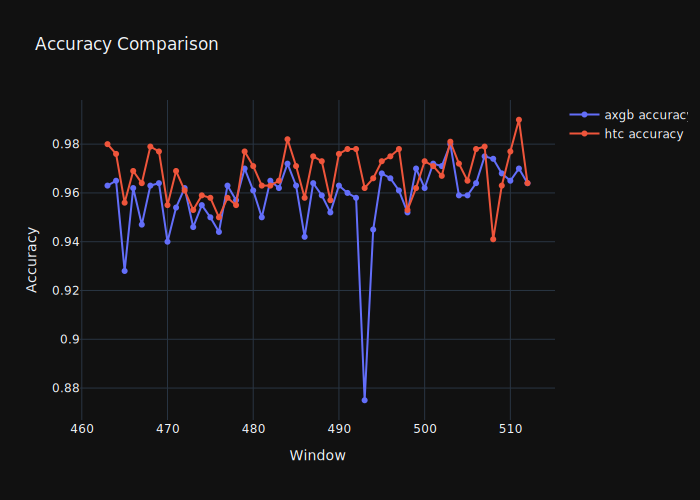

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=[item.index for item in axgb_accuracy],
    y=[item.metric for item in axgb_accuracy],
    mode='lines+markers',
    name='axgb accuracy'
))

fig.add_trace(go.Scatter(
    x=[item.index for item in htc_accuracy],
    y=[item.metric for item in htc_accuracy],
    mode='lines+markers',
    name='htc accuracy'
))


fig.update_layout(
    title="Accuracy Comparison",
    xaxis_title="Window",
    yaxis_title="Accuracy",
    template="plotly_dark"
)

fig.show("svg")

This plot compares the windowed accuracy of the TurboML's Adaptive XGBoost Model and the HTC Model across different windows.

## Model Inference Response Time

Initialize timer

In [ ]:
import time

class TimeTracker:
    def __init__(self):
        self.start_times = {}
        self.end_times = {}
        self.checkpoints = {}
        self.intervals = {}

    def start(self, label="default"):
        """Start the timer for a specific label."""
        self.start_times[label] = time.time()
        self.checkpoints[label] = [self.start_times[label]]
        self.intervals[label] = []
        print(f"Timer '{label}' started.")

    def checkpoint(self, label="default", note=None):
        """Record an intermediate checkpoint for the specified label."""
        if label not in self.start_times:
            raise ValueError(f"Timer '{label}' has not been started.")
        now = time.time()
        elapsed = now - self.checkpoints[label][-1]
        self.checkpoints[label].append(now)
        self.intervals[label].append(elapsed)
        time_elapsed_msg = f"Time elapsed {elapsed:.4f} seconds"
        if note:
            time_elapsed_msg += f" - {note}"
        print(time_elapsed_msg)

    def stop(self, label="default"):
        """Stop the timer for a specific label and return elapsed time."""
        if label not in self.start_times:
            raise ValueError(f"Timer '{label}' has not been started.")
        self.end_times[label] = time.time()
        elapsed = self.end_times[label] - self.start_times[label]
        print(f"Timer '{label}' stopped. Elapsed time: {elapsed:.4f} seconds")
        return elapsed

    def total_time(self, label="default"):
        """Get total elapsed time between start and stop for a label."""
        if label not in self.start_times or label not in self.end_times:
            raise ValueError(f"Timer '{label}' must be started and stopped.")
        return self.end_times[label] - self.start_times[label]

    def reset(self, label="default"):
        """Reset the timer for the specified label."""
        self.start_times.pop(label, None)
        self.end_times.pop(label, None)
        self.checkpoints.pop(label, None)
        print(f"Timer '{label}' has been reset.")

    def get_intervals(self, label="default"):
        """Get intervals for a specific label."""
        return self.intervals[label]

    def get_intervals_starts_with(self, label="default"):
        """Get intervals for label that starts with a specific prefix."""
        return {k: v for k, v in self.intervals.items() if k.startswith(label)}

# initialize timer
timer = TimeTracker()

Model endpoints are used to get inference for single datapoint.

In [ ]:
axgb_model_endpoint = deployed_axgb_model.get_endpoints()[0]
htc_model_endpoint = deployed_htc_model.get_endpoints()[0]
print(axgb_model_endpoint)
print(htc_model_endpoint)

https://crouching-chowchow.api.turboml.online/model/_turboml.axgb_model/predict
https://crouching-chowchow.api.turboml.online/model/_turboml.htc_model/predict


# Single datapoint inference using model endpoint

In [ ]:
with requests.Session() as session:
    test_resp = session.post(
      axgb_model_endpoint, json=ieee_features_df.iloc[0].to_dict(), headers=tb.common.api.headers
    )
    timer.reset("axgb_response_time")
    timer.start("axgb_response_time")
    for i in range(20):
      resp = session.post(
        axgb_model_endpoint, json=ieee_features_df.iloc[i].to_dict(), headers=tb.common.api.headers
      )
      timer.checkpoint("axgb_response_time")
    timer.stop("axgb_response_time")

with requests.Session() as session:
    test_resp = session.post(
      htc_model_endpoint, json=ieee_features_df.iloc[0].to_dict(), headers=tb.common.api.headers
    )
    timer.reset("htc_response_time")
    timer.start("htc_response_time")
    for i in range(20):
      resp = session.post(
        htc_model_endpoint, json=ieee_features_df.iloc[i].to_dict(), headers=tb.common.api.headers
      )
      timer.checkpoint("htc_response_time")
    timer.stop("htc_response_time")


Timer 'axgb_response_time' has been reset.
Timer 'axgb_response_time' started.
Time elapsed 0.2581 seconds
Time elapsed 0.2581 seconds
Time elapsed 0.2575 seconds
Time elapsed 0.2584 seconds
Time elapsed 0.2594 seconds
Time elapsed 0.2592 seconds
Time elapsed 0.2592 seconds
Time elapsed 0.2601 seconds
Time elapsed 0.2601 seconds
Time elapsed 0.2604 seconds
Time elapsed 0.2599 seconds
Time elapsed 0.2596 seconds
Time elapsed 0.2592 seconds
Time elapsed 0.2597 seconds
Time elapsed 0.2585 seconds
Time elapsed 0.2593 seconds
Time elapsed 0.2601 seconds
Time elapsed 0.2603 seconds
Time elapsed 0.2594 seconds
Time elapsed 0.2594 seconds
Timer 'axgb_response_time' stopped. Elapsed time: 5.1867 seconds
Timer 'htc_response_time' has been reset.
Timer 'htc_response_time' started.
Time elapsed 0.2643 seconds
Time elapsed 0.2651 seconds
Time elapsed 0.2647 seconds
Time elapsed 0.2646 seconds
Time elapsed 0.2646 seconds
Time elapsed 0.2646 seconds
Time elapsed 0.2644 seconds
Time elapsed 0.2645 sec

In [ ]:
average_axgb = sum(timer.get_intervals("axgb_response_time")) / len(timer.get_intervals("axgb_response_time"))
average_htc = sum(timer.get_intervals("htc_response_time")) / len(timer.get_intervals("htc_response_time"))

print("  Summary:   ")
print("=============")
print(f"Average response time for Adaptive XGBoost Model: {average_axgb:.4f} seconds")
print(f"Average response time for Hoeffding Tree Classifier Model: {average_htc:.4f} seconds")

  Summary:   
Average response time for Adaptive XGBoost Model: 0.2593 seconds
Average response time for Hoeffding Tree Classifier Model: 0.2633 seconds


## Plot graph
Model Inference Response Time (Single Datapoint)

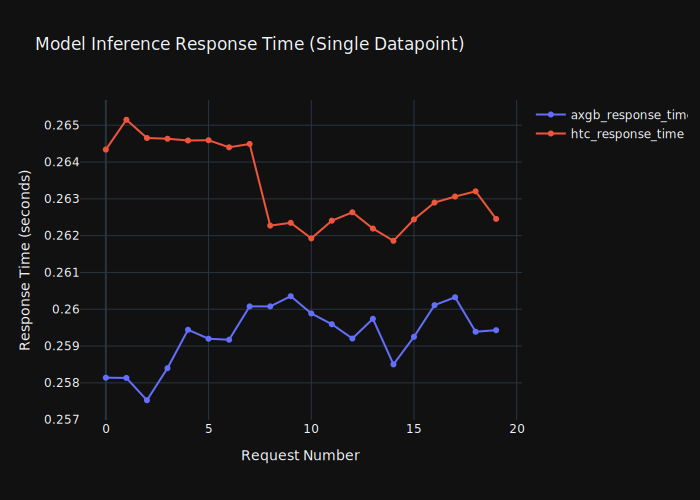

In [ ]:
# Create the Plotly figure
fig = go.Figure()

# Add traces for each response time
for model_name, response_times in timer.intervals.items():
    fig.add_trace(go.Scatter(
        x=list(range(len(response_times))),
        y=response_times,
        mode='lines+markers',
        name=model_name
    ))

# Update layout
fig.update_layout(
    title='Model Inference Response Time (Single Datapoint)',
    xaxis_title='Request Number',
    yaxis_title='Response Time (seconds)',
    template="plotly_dark"
)

# Show the plot
fig.show("svg")

The above plot shows the model inference response time (single datapoint) via POST request for Adaptive XG Boost model and HTC model. On average, the response time for the Adaptive XGBoost model is `259ms`, slightly outperforming the HTC model, which averages `263ms`.

# Batch Model Inference

In [ ]:
# check if intervals already stored
filename = "batch_inference_time_intervals.pkl"
if not os.path.exists(filename):
    batch_sizes = [100,1000,5000,10000,50000,100000]

    for size in batch_sizes:
      timer.start(f"inference_axgb_model_{size}")
      for i in range(5):
        outputs = deployed_axgb_model.get_inference(ieee_features_df.head(size))
        timer.checkpoint(f"inference_axgb_model_{size}")
      timer.stop(f"inference_axgb_model_{size}")

    for size in batch_sizes:
      timer.start(f"inference_htc_model_{size}")
      for i in range(5):
        outputs = deployed_htc_model.get_inference(ieee_features_df.head(size))
        timer.checkpoint(f"inference_htc_model_{size}")
      timer.stop(f"inference_htc_model_{size}")

    intervals = timer.intervals
    with open(filename, "wb") as f:
      pickle.dump(intervals, f)

else:
    with open(filename, "rb") as f:
      intervals = pickle.load(f)

Timer 'inference_axgb_model_100' started.


INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 444chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 624chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 4.0645 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 496chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 771chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 3.9307 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 835chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 873chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 3.9274 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 701chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 758chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 3.9533 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 734chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 910chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 3.8790 seconds
Timer 'inference_axgb_model_100' stopped. Elapsed time: 19.7550 seconds
Timer 'inference_axgb_model_1000' started.


INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.32chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.37chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 5.9856 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.33chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.33chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 6.0873 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.35chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.29chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 6.0706 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.30chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:01<00:00, 1.00s/chunk]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 6.5098 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.01chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.38chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 6.3338 seconds
Timer 'inference_axgb_model_1000' stopped. Elapsed time: 30.9878 seconds
Timer 'inference_axgb_model_5000' started.


INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 1.00/1.00 [00:01<00:00, 1.77s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 5.00/5.00 [00:01<00:00, 2.80chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 9.8325 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 1.00/1.00 [00:01<00:00, 1.74s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 5.00/5.00 [00:01<00:00, 3.97chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 8.5415 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 1.00/1.00 [00:01<00:00, 1.74s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 5.00/5.00 [00:01<00:00, 3.89chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 8.5657 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 1.00/1.00 [00:01<00:00, 1.76s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 5.00/5.00 [00:01<00:00, 3.95chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 8.7037 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 1.00/1.00 [00:01<00:00, 1.76s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 5.00/5.00 [00:01<00:00, 3.87chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 9.4790 seconds
Timer 'inference_axgb_model_5000' stopped. Elapsed time: 45.1227 seconds
Timer 'inference_axgb_model_10000' started.


INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress:  50%|█████     | 1.00/2.00 [00:02<00:02, 2.06s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress: 100%|██████████| 10.0/10.0 [00:01<00:00, 6.53chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 10.2670 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress:  50%|█████     | 1.00/2.00 [00:02<00:02, 2.26s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress: 100%|██████████| 10.0/10.0 [00:01<00:00, 6.44chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 10.2782 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress:  50%|█████     | 1.00/2.00 [00:02<00:02, 2.27s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress: 100%|██████████| 10.0/10.0 [00:01<00:00, 6.58chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 10.5444 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress:  50%|█████     | 1.00/2.00 [00:02<00:02, 2.27s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress: 100%|██████████| 10.0/10.0 [00:01<00:00, 6.67chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 10.3848 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress:  50%|█████     | 1.00/2.00 [00:02<00:02, 2.29s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress: 100%|██████████| 10.0/10.0 [00:02<00:00, 4.95chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 10.6192 seconds
Timer 'inference_axgb_model_10000' stopped. Elapsed time: 52.0938 seconds
Timer 'inference_axgb_model_50000' started.


INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress:  83%|████████▎ | 5.00/6.00 [00:08<00:01, 1.76s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress: 100%|██████████| 49.0/49.0 [00:03<00:00, 15.9chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 19.4134 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress:  83%|████████▎ | 5.00/6.00 [00:08<00:01, 1.71s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress: 100%|██████████| 49.0/49.0 [00:03<00:00, 15.9chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 18.9964 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress:  83%|████████▎ | 5.00/6.00 [00:08<00:01, 1.64s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress: 100%|██████████| 49.0/49.0 [00:03<00:00, 16.1chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 19.4033 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress:  83%|████████▎ | 5.00/6.00 [00:08<00:01, 1.61s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress: 100%|██████████| 49.0/49.0 [00:03<00:00, 15.8chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 18.6752 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress:  83%|████████▎ | 5.00/6.00 [00:08<00:01, 1.65s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress: 100%|██████████| 49.0/49.0 [00:03<00:00, 15.8chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 18.9047 seconds
Timer 'inference_axgb_model_50000' stopped. Elapsed time: 95.3933 seconds
Timer 'inference_axgb_model_100000' started.


INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress:  91%|█████████ | 10.0/11.0 [00:13<00:01, 1.33s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress: 100%|██████████| 98.0/98.0 [00:04<00:00, 20.1chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 30.1925 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress:  91%|█████████ | 10.0/11.0 [00:13<00:01, 1.37s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress: 100%|██████████| 98.0/98.0 [00:04<00:00, 20.1chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 28.1139 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress:  91%|█████████ | 10.0/11.0 [00:13<00:01, 1.37s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress: 100%|██████████| 98.0/98.0 [00:04<00:00, 20.2chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 29.6018 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress:  91%|█████████ | 10.0/11.0 [00:13<00:01, 1.40s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress: 100%|██████████| 98.0/98.0 [00:05<00:00, 19.3chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 29.5318 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress:  91%|█████████ | 10.0/11.0 [00:13<00:01, 1.33s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress: 100%|██████████| 98.0/98.0 [00:04<00:00, 20.4chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 28.8763 seconds
Timer 'inference_axgb_model_100000' stopped. Elapsed time: 146.3165 seconds
Timer 'inference_htc_model_100' started.


INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 753chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 314chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 3.9611 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 789chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 790chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 3.9152 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 852chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 707chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 3.9276 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 808chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 813chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 3.9284 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 935chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 851chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 3.9371 seconds
Timer 'inference_htc_model_100' stopped. Elapsed time: 19.6696 seconds
Timer 'inference_htc_model_1000' started.


INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.30chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.32chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 6.0800 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.31chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.33chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 6.0045 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.31chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.33chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 6.2626 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.34chunk/s]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.32chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 6.1438 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:01<00:00, 1.01s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 1000
Progress: 100%|██████████| 1.00/1.00 [00:00<00:00, 1.33chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 6.2461 seconds
Timer 'inference_htc_model_1000' stopped. Elapsed time: 30.7372 seconds
Timer 'inference_htc_model_5000' started.


INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 1.00/1.00 [00:01<00:00, 1.57s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 5.00/5.00 [00:01<00:00, 3.90chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 8.7086 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 1.00/1.00 [00:01<00:00, 1.77s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 5.00/5.00 [00:01<00:00, 3.95chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 8.5879 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 1.00/1.00 [00:01<00:00, 1.80s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 5.00/5.00 [00:01<00:00, 3.89chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 8.7350 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 1.00/1.00 [00:01<00:00, 1.77s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 5.00/5.00 [00:01<00:00, 3.94chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 8.3195 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 1.00/1.00 [00:01<00:00, 1.76s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 5000
Progress: 100%|██████████| 5.00/5.00 [00:01<00:00, 3.94chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 8.3989 seconds
Timer 'inference_htc_model_5000' stopped. Elapsed time: 42.7501 seconds
Timer 'inference_htc_model_10000' started.


INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress:  50%|█████     | 1.00/2.00 [00:02<00:02, 2.28s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress: 100%|██████████| 10.0/10.0 [00:01<00:00, 6.54chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 9.9626 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress:  50%|█████     | 1.00/2.00 [00:02<00:02, 2.24s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress: 100%|██████████| 10.0/10.0 [00:01<00:00, 6.60chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 10.6790 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress:  50%|█████     | 1.00/2.00 [00:02<00:02, 2.27s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress: 100%|██████████| 10.0/10.0 [00:01<00:00, 6.56chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 9.9045 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress:  50%|█████     | 1.00/2.00 [00:02<00:02, 2.28s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress: 100%|██████████| 10.0/10.0 [00:01<00:00, 6.62chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 9.7190 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress:  50%|█████     | 1.00/2.00 [00:02<00:02, 2.31s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 10000
Progress: 100%|██████████| 10.0/10.0 [00:01<00:00, 5.55chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 10.0832 seconds
Timer 'inference_htc_model_10000' stopped. Elapsed time: 50.3485 seconds
Timer 'inference_htc_model_50000' started.


INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress:  83%|████████▎ | 5.00/6.00 [00:08<00:01, 1.73s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress: 100%|██████████| 49.0/49.0 [00:03<00:00, 15.8chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 16.9204 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress:  83%|████████▎ | 5.00/6.00 [00:08<00:01, 1.64s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress: 100%|██████████| 49.0/49.0 [00:03<00:00, 15.9chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 16.7048 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress:  83%|████████▎ | 5.00/6.00 [00:08<00:01, 1.68s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress: 100%|██████████| 49.0/49.0 [00:03<00:00, 15.8chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 18.3192 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress:  83%|████████▎ | 5.00/6.00 [00:08<00:01, 1.65s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress: 100%|██████████| 49.0/49.0 [00:03<00:00, 16.0chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 16.9904 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress:  83%|████████▎ | 5.00/6.00 [00:08<00:01, 1.68s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 50000
Progress: 100%|██████████| 49.0/49.0 [00:03<00:00, 15.8chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 17.0088 seconds
Timer 'inference_htc_model_50000' stopped. Elapsed time: 85.9444 seconds
Timer 'inference_htc_model_100000' started.


INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress:  91%|█████████ | 10.0/11.0 [00:13<00:01, 1.37s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress: 100%|██████████| 98.0/98.0 [00:04<00:00, 20.8chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 26.3191 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress:  91%|█████████ | 10.0/11.0 [00:13<00:01, 1.37s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress: 100%|██████████| 98.0/98.0 [00:04<00:00, 20.4chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 25.0784 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress:  91%|█████████ | 10.0/11.0 [00:13<00:01, 1.39s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress: 100%|██████████| 98.0/98.0 [00:04<00:00, 20.4chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 25.2770 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress:  91%|█████████ | 10.0/11.0 [00:13<00:01, 1.37s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress: 100%|██████████| 98.0/98.0 [00:04<00:00, 20.1chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 25.2774 seconds


INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress:  91%|█████████ | 10.0/11.0 [00:13<00:01, 1.37s/chunk]
INFO:turboml.common.internal:Completed data upload.
INFO:turboml.common.internal:Starting to upload data... Total rows: 100000
Progress: 100%|██████████| 98.0/98.0 [00:04<00:00, 21.2chunk/s]
INFO:turboml.common.internal:Completed data upload.


Time elapsed 25.2736 seconds
Timer 'inference_htc_model_100000' stopped. Elapsed time: 127.2257 seconds


# Plot graphs

Model Batch Inference Time

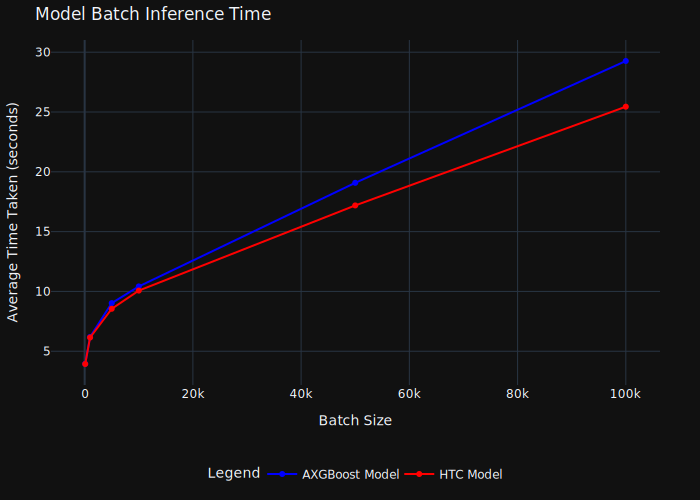

In [ ]:
intervals_axgb = {key: values for key, values in intervals.items() if "inference_axgb" in key}
intervals_htc = {key: values for key, values in intervals.items() if "inference_htc" in key}

# Calculate averages for each size
averages_axgb = {key: sum(values) / len(values) for key, values in intervals_axgb.items()}
sizes_axgb = [int(key.split('_')[3]) for key in averages_axgb.keys()]
average_times_axgb = list(averages_axgb.values())

averages_htc = {key: sum(values) / len(values) for key, values in intervals_htc.items()}
sizes_htc = [int(key.split('_')[3]) for key in averages_htc.keys()]
average_times_htc = list(averages_htc.values())

# Plot individual graphs and a combined graph
fig = go.Figure()

# Add the average line
fig.add_trace(go.Scatter(
    x=sizes_axgb,
    y=average_times_axgb,
    mode='lines+markers',
    name='AXGBoost Model',
    line=dict(color='blue', width=2)
))

# Add the average line
fig.add_trace(go.Scatter(
    x=sizes_htc,
    y=average_times_htc,
    mode='lines+markers',
    name='HTC Model',
    line=dict(color='red', width=2)
))

# Customize the layout
fig.update_layout(
    title="Model Batch Inference Time",
    xaxis_title=f"Batch Size ",
    yaxis_title="Average Time Taken (seconds)",
    template="plotly_dark",
    legend=dict(title="Legend", orientation="h", yanchor="bottom", y=-0.3, xanchor="center", x=0.5),
    margin=dict(l=40, r=40, t=40, b=40)
)

# Show the figure
fig.show("svg")

The plot above shows the average inference time for two models, AXGBoost and HTC, across varying batch sizes of `[100,1k,5k,10k,50k,100k]`. The x-axis represents batch sizes, while the y-axis shows the average time taken (in seconds) for batch inference.



Model Batch Inference Time: Rows Per Second

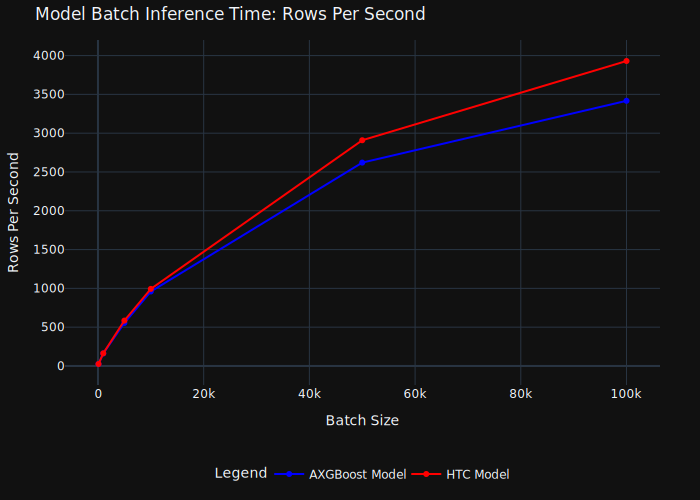

In [ ]:
# Calculate Rows Per Second (RPS)
rps_axgb = {size: size / avg_time for size, avg_time in zip(sizes_axgb, averages_axgb.values())}
rps_htc = {size: size / avg_time for size, avg_time in zip(sizes_htc, averages_htc.values())}


# Plot individual graphs and a combined graph
fig = go.Figure()


# Add the average line
fig.add_trace(go.Scatter(
    x=sizes_axgb,
    y=[rps_axgb[size] for size in sizes_axgb],
    mode='lines+markers',
    name='AXGBoost Model',
    line=dict(color='blue', width=2)
))

# Add the average line
fig.add_trace(go.Scatter(
    x=sizes_htc,
    y=[rps_htc[size] for size in sizes_htc],
    mode='lines+markers',
    name='HTC Model',
    line=dict(color='red', width=2)
))

# Customize the layout
fig.update_layout(
    title="Model Batch Inference Time: Rows Per Second",
    xaxis_title=f"Batch Size",
    yaxis_title="Rows Per Second",
    template="plotly_dark",
    legend=dict(title="Legend", orientation="h", yanchor="bottom", y=-0.3, xanchor="center", x=0.5),
    margin=dict(l=40, r=40, t=40, b=40)
)

# Show the figure
fig.show("svg")

The plot above shows the batch inference throughput (rows per second) of the AXGBoost model (blue line) and the HTC model (red line) across different batch sizes. Key observations and inferences include:

- **Throughput Increases with Batch Size**: Both models demonstrate higher throughput as batch size increases, which is typical for batch processing due to better utilization of computational resources.